In [16]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from projection_engine import ProjectionEngine
from dotenv import load_dotenv
import pdb

load_dotenv()

True

In [ ]:
## Assumptions
# Exclude 13th month, holiday bonus (15%)

GROSS_SALARY_HYUNMIN = float(os.getenv("GROSS_SALARY_HYUNMIN"))
GROSS_SALARY_JAENE = float(os.getenv("GROSS_SALARY_JAENE"))
GROCERY = float(os.getenv("GROCERY"))
SUBSCRIPTION = float(os.getenv("SUBSCRIPTION"))
LESSON = float(os.getenv("LESSON"))
INVESTMENT = float(os.getenv("INVESTMENT"))
CASH = float(os.getenv("CASH"))
INSURANCE_HYUNMIN = float(os.getenv("INSURANCE_HYUNMIN"))
INSURANCE_JAENE = float(os.getenv("INSURANCE_JAENE"))
ANNUAL_RTN = float(os.getenv("ANNUAL_RTN"))
ZORGTOESLAG = os.getenv("ZORGTOESLAG") == "True"
HUURTOESLAG = os.getenv("HUURTOESLAG") == "True"

env_config = {
    "gross_salary1": GROSS_SALARY_HYUNMIN,
    "gross_salary2": GROSS_SALARY_JAENE,
    "grocery": GROCERY,
    "subscription": SUBSCRIPTION,
    "lesson": LESSON,
    "investment": INVESTMENT,
    "cash": CASH,
    "insurance1": INSURANCE_HYUNMIN,
    "insurance2": INSURANCE_JAENE,
    "annual_rtn": ANNUAL_RTN,
    "zorgtoeslag": ZORGTOESLAG,
    "huurtoeslag": HUURTOESLAG
}

engine = ProjectionEngine(**env_config)

print("Net salary (Hyunmin):", engine.salary1)
print("Net salary (Jaene):", engine.salary2)
print("Living cost:", engine.living_cost)
print("Remainder per person:", engine.remainder_acc / 2)

Net salary (Hyunmin): 3642.74
Net salary (Jaene): 3152.83
Living cost: 1200.0
Remainder per person: 1147.7849999999999


In [15]:
years_total = 10
house_price = 600_000
cash_dp_fixed = 0.5
purchase_year = 4

inv_dp_grid = np.linspace(0.0, 1.0, 21)   
year_grid = range(1, min(years_total, purchase_year + 1))  

records = []
for yr in year_grid:
    for inv_dp in inv_dp_grid:
        feasible, loan_amt = engine.is_feasible_purchase(
            years_until_purchase=yr,
            down_payment=(inv_dp, cash_dp_fixed),
            market_value=house_price,
        )
        if not feasible:
            continue  

        proj_inv, proj_cash, annuity = engine.project_with_purchase(
            years_total=years_total,
            years_until_purchase=yr,
            down_payment=(inv_dp, cash_dp_fixed),
            market_value=house_price,
            mortgage_rate=0.0379,
            mortgage_term=30,
        )
        final_wealth = proj_inv[-1] + proj_cash[-1]
        records.append((yr, inv_dp, final_wealth, loan_amt, annuity))

if records:
    best = max(records, key=lambda r: r[2])
    print(f"Best year: {best[0]} | Best investment DP: {best[1]*100:.1f}% "
          f"| Final wealth: €{best[2]:,.0f} | Loan: €{best[3]:,.0f} | Annuity: €{best[4]:,.0f}")
else:
    print("No feasible combinations under the 5× income mortgage cap.")

Best year: 4 | Best investment DP: 35.0% | Final wealth: €526,693 | Loan: €521,592 | Annuity: €2,427


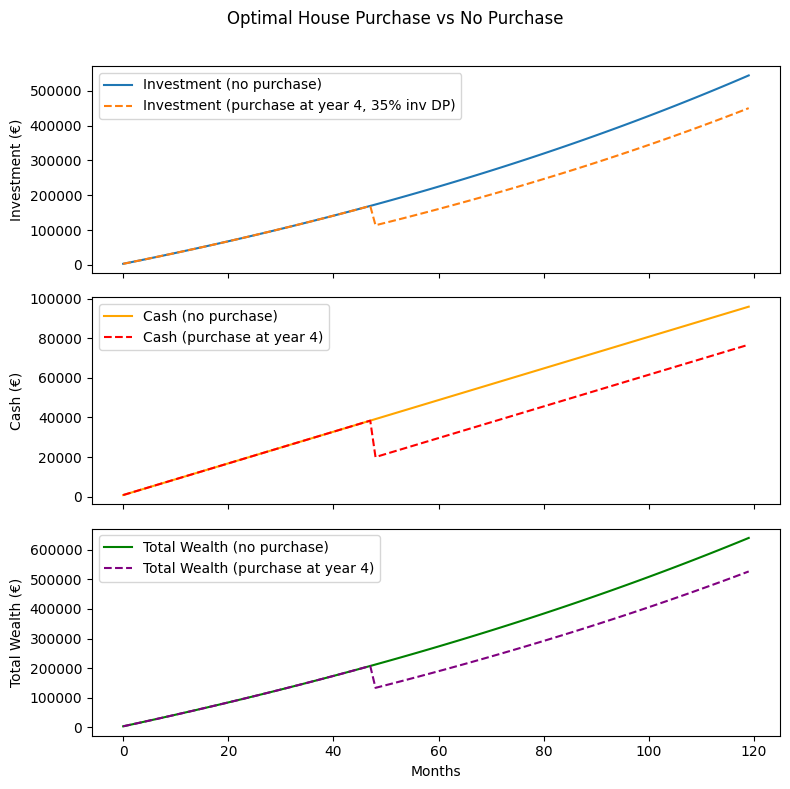

Total Wealth (no house purchase): €639,849.59
Total Wealth (purchase at year 4, 35% inv DP): €526,693.27
Monthly Annuity: €2,427.43


In [13]:
# Baseline: no purchase
proj_inv_base, proj_cash_base = engine.projection_wealth(years_total)
proj_total_base = proj_inv_base + proj_cash_base

# Optimal purchase scenario
best_year, best_inv_dp, best_total, best_loan, best_annuity = best
proj_inv_opt, proj_cash_opt, _ = engine.project_with_purchase(
    years_total=years_total,
    years_until_purchase=best_year,
    down_payment=(best_inv_dp, cash_dp_fixed),
    market_value=house_price,
    mortgage_rate=0.0379,
    mortgage_term=30,
)
proj_total_opt = proj_inv_opt + proj_cash_opt

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# Investment
axs[0].plot(proj_inv_base, label="Investment (no purchase)")
axs[0].plot(proj_inv_opt, label=f"Investment (purchase at year {best_year}, {best_inv_dp*100:.0f}% inv DP)", linestyle="--")
axs[0].set_ylabel("Investment (€)")
axs[0].legend()

# Cash
axs[1].plot(proj_cash_base, label="Cash (no purchase)", color="orange")
axs[1].plot(proj_cash_opt, label=f"Cash (purchase at year {best_year})", color="red", linestyle="--")
axs[1].set_ylabel("Cash (€)")
axs[1].legend()

# Total wealth
axs[2].plot(proj_total_base, label="Total Wealth (no purchase)", color="green")
axs[2].plot(proj_total_opt, label=f"Total Wealth (purchase at year {best_year})", color="purple", linestyle="--")
axs[2].set_ylabel("Total Wealth (€)")
axs[2].set_xlabel("Months")
axs[2].legend()

plt.suptitle("Optimal House Purchase vs No Purchase")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Final results
print(f"Total Wealth (no house purchase): €{proj_total_base[-1]:,.2f}")
print(f"Total Wealth (purchase at year {best_year}, {best_inv_dp*100:.0f}% inv DP): €{proj_total_opt[-1]:,.2f}")
print(f"Monthly Annuity: €{best_annuity:,.2f}")
